# 출력층 설계 (Output layer)


**회귀 vs 분류 출력층 비교표**


| 항목           | **회귀 (Regression)**            | **이진 분류 (Binary Classification)**        | **다중 분류 (Multi-class Classification)** |
| ------------ | ------------------------------ | ---------------------------------------- | -------------------------------------- |
| **출력층 뉴런 수** | 1개                             | 1개                                       | 클래스 수만큼 (예: 3개 클래스 → 3개 뉴런)            |
| **활성화 함수**   | 없음 (`Identity` = 항등함수)         | `Sigmoid`                                | 없음 (출력은 로짓값, softmax는 loss 내부 처리)      |
| **손실 함수**    | `MSELoss`, `L1Loss` 등          | `BCELoss`, `BCEWithLogitsLoss`           | `CrossEntropyLoss` (Softmax 포함)        |
| **정답 레이블**   | 실수 (float32), shape = `(n, 1)` | 0 또는 1 (float or long), shape = `(n, 1)` | 정수 (long), shape = `(n,)`              |
| **예측 방식**    | 그대로 출력 사용 (`ŷ`)                | `ŷ >= 0.5` → 1, else 0                   | `argmax(output, dim=1)`                |


<br/>


> 회귀는 **출력값에 제한이 없으므로** 아무 활성화도 적용하지 않음
>
> 이진 분류는 **확률**을 출력해야 하므로 sigmoid를 씌움. `BCEWithLogitsLoss` 사용하는 경우에는 **출력층에서는 sigmoid를 쓰지 않음**
>
> 다중 분류는 `CrossEntropyLoss`가 내부적으로 `Softmax` + `Log`를 처리하므로 **출력층에서는 softmax를 쓰지 않음**
# 출력층 설계 (Output layer)


**회귀 vs 분류 출력층 비교표**


| 항목           | **회귀 (Regression)**            | **이진 분류 (Binary Classification)**        | **다중 분류 (Multi-class Classification)** |
| ------------ | ------------------------------ | ---------------------------------------- | -------------------------------------- |
| **출력층 뉴런 수** | 1개                             | 1개                                       | 클래스 수만큼 (예: 3개 클래스 → 3개 뉴런)            |
| **활성화 함수**   | 없음 (`Identity` = 항등함수)         | `Sigmoid`                                | 없음 (출력은 로짓값, softmax는 loss 내부 처리)      |
| **손실 함수**    | `MSELoss`, `L1Loss` 등          | `BCELoss`, `BCEWithLogitsLoss`           | `CrossEntropyLoss` (Softmax 포함)        |
| **정답 레이블**   | 실수 (float32), shape = `(n, 1)` | 0 또는 1 (float or long), shape = `(n, 1)` | 정수 (long), shape = `(n,)`              |
| **예측 방식**    | 그대로 출력 사용 (`ŷ`)                | `ŷ >= 0.5` → 1, else 0                   | `argmax(output, dim=1)`                |


<br/>


> 회귀는 **출력값에 제한이 없으므로** 아무 활성화도 적용하지 않음
>
> 이진 분류는 **확률**을 출력해야 하므로 sigmoid를 씌움. `BCEWithLogitsLoss` 사용하는 경우에는 **출력층에서는 sigmoid를 쓰지 않음**
>
> 다중 분류는 `CrossEntropyLoss`가 내부적으로 `Softmax` + `Log`를 처리하므로 **출력층에서는 softmax를 쓰지 않음**


## 회귀 출력층
항등함수란? $f(x) = x$와 같이 입력이 곧 출력인 함수를 가리킨다. torch모델에서는 출력층 다음에 활성화 함수를 사용하지 않는다.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

In [6]:
# 데이터 생성
# X (100, 2)
# y (100, 1)

X = torch.randn(100, 2)
W = torch.tensor([[3., 2.]]) #(1, 2)
b = torch.tensor([5.])
noise = torch.randn(100, 1) * 2
                     # 100행 1열짜리 / 2: 표준편차를 늘려줌 0.5: 표준편차를 줄여줌

print(noise)

y = X @ W.T + b
print(y.shape)

tensor([[-0.0065],
        [-2.4653],
        [ 0.2957],
        [-0.7615],
        [ 1.2525],
        [ 0.8114],
        [ 4.6181],
        [-1.0669],
        [ 0.3643],
        [-3.1690],
        [ 0.5264],
        [ 1.1717],
        [ 0.4144],
        [ 0.0299],
        [-4.6379],
        [ 1.5310],
        [ 0.0064],
        [ 0.3769],
        [-1.2602],
        [-3.6421],
        [-1.3267],
        [-1.6724],
        [-0.4058],
        [-0.4932],
        [-0.7995],
        [-0.0324],
        [-4.4070],
        [ 2.2767],
        [ 0.0941],
        [-1.0715],
        [-0.6316],
        [ 3.5163],
        [-0.9611],
        [-0.8587],
        [ 0.4865],
        [-2.6784],
        [ 1.1016],
        [-1.3419],
        [-0.9338],
        [-2.4419],
        [-2.6800],
        [ 1.8323],
        [-0.7557],
        [ 0.3193],
        [ 0.4720],
        [ 1.6864],
        [ 0.4676],
        [-0.4949],
        [ 2.3189],
        [ 0.4635],
        [ 0.4810],
        [-0.8593],
        [ 1.

In [7]:
# 모델 생성
class RegressionNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden = nn.Linear(input_dim, 10) # 입력 2 -> 출력 10
        self.relu = nn.ReLU()
        self.output = nn.Linear(10, 1) # 입력이 10 -> 출력 1


    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x


model = RegressionNet(input_dim=X.size()[1])
criterion = nn.MSELoss() # 얘가 가장 끌만함
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
# 학습
for epoch in range(1000):
    model.train() # 학습모드
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y)
    loss.backward() # 기울기 계산(역전파)
    optimizer.step() # 가중치 계산


    if (epoch + 1) % 100 == 0:
        print( f'Epoch: {epoch + 1} / Loss: {loss.item()}')

Epoch: 100 / Loss: 1.6080796718597412
Epoch: 200 / Loss: 0.37697598338127136
Epoch: 300 / Loss: 0.09963788092136383
Epoch: 400 / Loss: 0.06137135624885559
Epoch: 500 / Loss: 0.042960476130247116
Epoch: 600 / Loss: 0.03047856129705906
Epoch: 700 / Loss: 0.019671199843287468
Epoch: 800 / Loss: 0.01337769627571106
Epoch: 900 / Loss: 0.010357670485973358
Epoch: 1000 / Loss: 0.00654191616922617


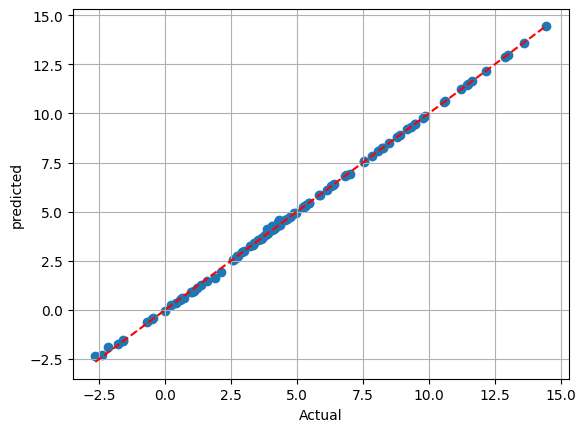

In [9]:
# 예측/시각화
import matplotlib.pyplot as plt
#torch.no_grad() 블럭 : 자동미분 연산 안하는 블럭(loss.backward() 사용 불가)
# model.eval() : 모델의 펴악모드 활성화(Dropout 시각화)
# 드랍아웃 : 학습 중에 일부 뉴런을 랜덤으로 꺼서 모델이 특정 뉴런에만 의존하지 못하게 만드는 과적합 방지 기법
with torch.no_grad():
    model.eval()
    pred = model(X)

plt.scatter(y, pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label = 'True')
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.grid()

plt.show()

In [10]:
# 은닉층 가중치/절편 shape :(10, 2)(10,)
# 출력층 가중치/절편 shape :(1, 10)(1,)

for name, param in model.named_parameters():
    print(f'{name} : {param.shape}')


hidden.weight : torch.Size([10, 2])
hidden.bias : torch.Size([10])
output.weight : torch.Size([1, 10])
output.bias : torch.Size([1])


## 캘리포니아 집값 예측


In [11]:
from sklearn.datasets import fetch_california_housing, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(as_frame = True, return_X_y=True)
print(X.shape, y.shape)


# 데이터 전처리
X_scaler = StandardScaler()
y_scaler = StandardScaler() # 딥러닝은 학습 안정성을 이유로 라벨 스케일링도 진행해야한다.

X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# - tensor 변환
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

(20640, 8) (20640,)


In [12]:
# 모델 생성

class CaliforniaHousingNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.hidden2 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        self.output = nn.Linear(16, 1) # 1이 들어가야함 1이니까. 여기서는 활성화함수 X

        def forward(self, x):
            x = self.hidden1(x)
            x = self.relu(x)
            x = self.hidden2(x)
            x = self.relu(x)
            x = self.output(x)

            return x



In [13]:
# 모델 생성

class CaliforniaHousingNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        # 모듈 객체를 순서대로 묶고 실행 (forward 구현)
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
    def forward(self, x):
        return self.net(x)

model = CaliforniaHousingNet(input_dim=X.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
# 모델 학습

# epoch수 만큼 반복
for epoch in range(1000) :

    # 학습모드 활성화
    model.train()
    # 최적화함수 초기화
    optimizer.zero_grad()
    # 모델예측
    pred = model(X_train)
    # 손실계산
    loss = criterion(pred, y_train)
    # 역전파(기울기 계산)
    loss.backward()
    # 가중치/절편 업데이트
    optimizer.step()

    # 100번마다 손실 로깅
    if (epoch + 1) % 100 == 0:
        print(f'Epoch: {epoch + 1} / Loss: {loss.item()}')



Epoch: 100 / Loss: 0.2505539357662201
Epoch: 200 / Loss: 0.205327108502388
Epoch: 300 / Loss: 0.19614708423614502
Epoch: 400 / Loss: 0.18870027363300323
Epoch: 500 / Loss: 0.1862305849790573
Epoch: 600 / Loss: 0.18374758958816528
Epoch: 700 / Loss: 0.18069295585155487
Epoch: 800 / Loss: 0.17899189889431
Epoch: 900 / Loss: 0.17932023108005524
Epoch: 1000 / Loss: 0.17677165567874908


In [15]:
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    root_mean_squared_error
)


# 평가/시각화
model.eval()


with torch.no_grad():
    pred = model(X_test)

# 라벨 스케일링값을 원복해서 평가
y_test_inv = y_scaler.inverse_transform(y_test)
pred_inv = y_scaler.inverse_transform(pred)


# 평가
print(f'R : {r2_score(y_test_inv, pred_inv)}')
print(f'MSE : {mean_squared_error(y_test_inv, pred_inv)}')
print(f'MAE: {mean_absolute_error(y_test_inv, pred_inv)}')
print(f'RMSE : {root_mean_squared_error(y_test_inv, pred_inv)}')

R : 0.7981708938503516
MSE : 0.2644786763891111
MAE: 0.3456514482884319
RMSE : 0.5142749035186445


TypeError: max expected at least 1 argument, got 0

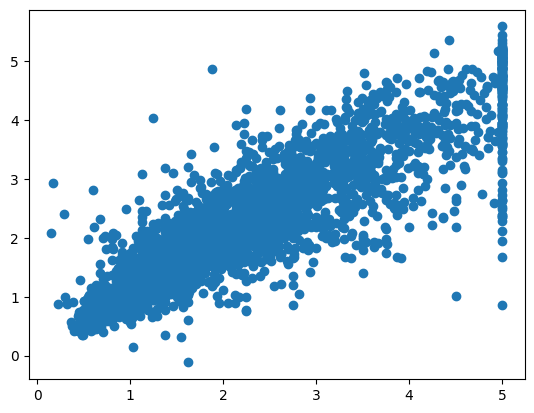

In [16]:
# 시각화
# - 산점도 : x축 실제값, y 예측갑
plt.scatter(y_test_inv, pred_inv)
plt.plot([0, y_test_inv,max()], [0, y_test_inv.max()], 'r--', label='True')
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.legend()
plt.grid()

# - 선그래프(기준선) : (0,0) -> (최대실제값, 최대실제값)
plt.show()

### 이진분류
- Sigmoid 활성화 함수 사용
- 은닉층/출력층 거쳐온 결과(z)을 확률값(p)으로 변환
- 설정한 임계치 이상이면 양성으로 예측

In [62]:
torch.manual_seed(42)

# 평균 0, 표준편차 10인 정규분포 샘플링 10개
z = torch.randn(10) * 10
# print(f'z: {z}')

p = F.sigmoid(z)
# print(f'p: {p}')

# 더 많은 양성클래스를 확보하고 싶다면(재현율), 임계치를 낮추면 된다.
# 양성클래스의 정밀도를 높이고 싶다면, 임계치를 높이면 된다.
threshold = 0.8
pred = (p >= threshold).int()

pd.DataFrame({
    'z' : z,
    'p' : p,
    'pred' : pred,
})




,z,p,pred
0,3.366904,0.966654,1
1,1.288094,0.783824,0
2,2.344624,0.912506,1
3,2.303330,0.909152,1
4,-11.228563,0.000013,0
5,-1.863283,0.134321,0
6,22.082014,1.000000,1
7,-6.379971,0.001692,0
8,4.616572,0.990210,1
9,2.673509,0.935445,1


### 다중분류
- Softmax 활성화함수 사용
- 각 클래스별 계산값을 입력으로 받아, 각 클래스별 확률값으로 변환(모든 클래스의 확률값 합 1)
- 벡터를 입력받아 벡터로 변환

In [68]:
# 데이터 샘플이 한 건인 경우
z = torch.tensor([[2., 1.5, 4, 0.7],
                 [3., 1, 4.7, 5]])
print(z)
output = F.softmax(z, dim=1)

print(output)

pred = output.argmax(dim=1) # 행중에서 가장 값이 큰 애
print(pred) #0.7973, 0.5279 -> output 결과 나온거에서 인덱스 번호

# softmax 결과의 합은 항상 1
print(output.sum(dim=1))

tensor([[2.0000, 1.5000, 4.0000, 0.7000],
        [3.0000, 1.0000, 4.7000, 5.0000]])
tensor([[0.1079, 0.0654, 0.7973, 0.0294],
        [0.0714, 0.0097, 0.3910, 0.5279]])
tensor([2, 3])
tensor([1.0000, 1.0000])


In [69]:
# (참고) 다중클래스 예측에 sigmoid를 사용하는 경우
z = torch.tensor([[2., 1.5, 4, 0.7],
                 [3., 1, 4.7, 5]])
print(z)

# 각 클래스별로 양성일 확률을 반환 (모두의 합이 1이 아니다)
p = F.sigmoid(z)
print(p)

# 예측
pred = p.argmax(dim=1)
print(pred)


tensor([[2.0000, 1.5000, 4.0000, 0.7000],
        [3.0000, 1.0000, 4.7000, 5.0000]])
tensor([[0.8808, 0.8176, 0.9820, 0.6682],
        [0.9526, 0.7311, 0.9910, 0.9933]])
tensor([2, 3])


### 출력층과 손실함수 연계

**이진분류**
- 출력층 sigmoid + 손실함수 BCELoss
- 출력층 x + 손실함수 BCEWithLogitLoss


**다중분류**
- 출력층 x + 손실함수 CrossEntropyLoss


### 이진분류 : 출력층 sigmoid + 손실함수 BCELoss


In [144]:
from sklearn.datasets import make_classification


X, y = make_classification(
    n_samples=100, # 데이터 수
    n_features=10, # 특성 수
    n_informative=5, # 중요한 속성 수
    n_classes=2, # 예측클래스(이진분류)
    random_state=42

)

print(X.shape, y.shape)

# 데이터준비 (tensor 타입)
X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32).reshape(-1, 1) # 2차원 변경
# print(X.size(0))
print(X.shape, y.shape)

(100, 10) (100,)
100
torch.Size([100, 10]) torch.Size([100, 1])


In [26]:
# 모델 생성
class BinaryClassificationNet(nn.Module):
    def __init__(self, input_dim): # 10
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.net(x)

print(X.size(1))
model = BinaryClassificationNet(input_dim=X.shape[1])
criterion = nn.BCELoss() # 출력층 sigmoid가 반환한 확률값을 가지고 손실계산
# 시그모이드 쓸거면 BCELoss
optimizer = optim.Adam(model.parameters(), lr=0.01)

10


In [29]:
# 모델 학습
epochs = 100
model.train()

for epoch in range(epochs) :
 optimizer.zero_grad() # 초기화
 pred = model(X)
 loss = criterion(pred, y) # 100개 샘플 오차의 평균값 (스칼라)
 loss.backward()
 optimizer.step()

 if (epoch + 1) % 10 == 0 :
  print(f'Epoch: {epoch + 1} / Loss: {loss.item()}')



Epoch: 10 / Loss: 0.0011573551455512643
Epoch: 20 / Loss: 0.0010624255519360304
Epoch: 30 / Loss: 0.0009793443605303764
Epoch: 40 / Loss: 0.0009058326249942183
Epoch: 50 / Loss: 0.0008407029672525823
Epoch: 60 / Loss: 0.0007825742941349745
Epoch: 70 / Loss: 0.0007303200545720756
Epoch: 80 / Loss: 0.0006834864616394043
Epoch: 90 / Loss: 0.0006406218744814396
Epoch: 100 / Loss: 0.0006014202372170985


### 출력층 x + 손실함수 BCEWithLogitLoss

In [21]:
# 모델 생성
class BinaryClassificationNet2(nn.Module):
    def __init__(self, input_dim): # 10
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )


    def forward(self, x):
        return self.net(x) # sigmoid 활성화함수를 사용하지 않으므로,
                           # 확률값이 아닌 선형방정식 값이 반환


# print(X.size(1))
model = BinaryClassificationNet2(input_dim=X.shape[1]) # 입력데이터 특성 수
criterion = nn.BCEWithLogitsLoss() # 내부적으로 sigmoid 활성화함수 처리
# 시그모이드 안쓸거면 BCEWithLogisLoss
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [30]:
# 모델 학습
epochs = 100
model.train()

for epoch in range(epochs) :
 optimizer.zero_grad()
 logits = model(X)
 loss = criterion(logits, y) # L
 loss.backward()
 optimizer.step()

 if (epoch + 1) % 10 == 0 :
     print(f'Epoch: {epoch + 1} / Loss: {loss.item()}')





Epoch: 10 / Loss: 0.0005657408619299531
Epoch: 20 / Loss: 0.0005333118024282157
Epoch: 30 / Loss: 0.000503707502502948
Epoch: 40 / Loss: 0.0004765846242662519
Epoch: 50 / Loss: 0.0004518519272096455
Epoch: 60 / Loss: 0.0004291003860998899
Epoch: 70 / Loss: 0.00040806306060403585
Epoch: 80 / Loss: 0.00038855403545312583
Epoch: 90 / Loss: 0.000370386173017323
Epoch: 100 / Loss: 0.00035349029349163175


In [145]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)
print(X.shape, y.shape)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y)

# 데이터 전처리
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.dtype) # float64 # 지정 안하면 64로 지정
# 정확도가 올라가는 장점이 있긴 한데 사이즈가 커진다. 그래서 32로 지정해야함


# Tensor 데이터 준비
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype = torch.float32).unsqueeze(-1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(569, 30) (569,)
float64
torch.Size([455, 30]) torch.Size([455])
torch.Size([114, 30]) torch.Size([114])


In [55]:
# 모델 작성
class BreastCancerNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )


    def forward(self, x):
        return self.net(x)


# 모델/ 손실함수 / 최적화함수 선언
model = BreastCancerNet(input_dim=X_train.size(1))
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



In [56]:
# 모델 학습
model.train()

for epoch in range(100) :
     optimizer.zero_grad()
     pred = model(X_train) # 로짓
     loss = criterion(pred, y_train)
     loss.backward()
     optimizer.step()

     if (epoch + 1) % 10 == 0 :
         print(f'Epoch: {epoch + 1} / Loss: {loss.item()}')



Epoch: 10 / Loss: 0.19136127829551697
Epoch: 20 / Loss: 0.0707453191280365
Epoch: 30 / Loss: 0.05073774233460426
Epoch: 40 / Loss: 0.03499941527843475
Epoch: 50 / Loss: 0.026370670646429062
Epoch: 60 / Loss: 0.01842529885470867
Epoch: 70 / Loss: 0.01126191858202219
Epoch: 80 / Loss: 0.006001136265695095
Epoch: 90 / Loss: 0.0030067921616137028
Epoch: 100 / Loss: 0.0014991017524152994


In [65]:
from sklearn.metrics import accuracy_score
# 모델 평가
model.eval()
with torch.no_grad() :
    logits = model(X_test)
    p = F.sigmoid(logits)
    print(p) # 0~1사이
    pred = (p >=0.5).int()
    # print(pred)
    print('정확도:', accuracy_score(y_test, pred))


    # 레이어의 수라던가 노드의 수, 반복의 수를 바꿔가면서 학습해보자

tensor([[9.6851e-22],
        [1.0000e+00],
        [3.6553e-08],
        [3.9230e-02],
        [1.8869e-25],
        [1.0000e+00],
        [1.0000e+00],
        [1.6278e-16],
        [2.3018e-14],
        [2.2761e-31],
        [1.0000e+00],
        [4.2844e-11],
        [1.0000e+00],
        [2.4650e-13],
        [4.2090e-10],
        [9.9068e-01],
        [3.9655e-02],
        [9.7804e-01],
        [1.0000e+00],
        [1.0000e+00],
        [2.4355e-10],
        [9.8365e-05],
        [1.0000e+00],
        [1.0000e+00],
        [9.9994e-01],
        [9.9465e-01],
        [2.5697e-23],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [8.7206e-01],
        [3.0554e-14],
        [5.5227e-04],
        [1.0000e+00],
        [6.8744e-01],
        [6.8035e-03],
        [5.5972e-15],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [3.9851e-20],
        [9.1238e-10],
        [9

### 출력층 x + 손실함수 CrossEntropyLoss

In [70]:
# 데이터 생성
X = torch.randn(4, 5) # 정규분포, 4개의 데이터샘플, 5개의 특성
y = torch.tensor([0, 2, 1, 0]) # 라벨 자료형 long
n_classes = len(y.unique())
n_classes

3

In [72]:
# 모델 생성
class MultiClassificationNet(nn.Module):
    def __init__(self, input_dim, n_classes): # 정답을 받아야함
        super().__init__()
        self.net = nn.Sequential(# 묶어주고 순서대로 실행해줌
            nn.Linear(input_dim, 32), # 은닉층
            nn.ReLU(),
            nn.Linear(32, n_classes) # 출력층 # 정답이 3개라서 출력층이 3으로 있어야함


        )
    def forward(self, x):
        return self.net(x)
model = MultiClassificationNet(input_dim=X.size(1), n_classes=n_classes)
criterion = nn.CrossEntropyLoss() # softmax 내장
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [78]:
# 모델 학습
model.train()

for epoch in range(100) :
     optimizer.zero_grad()
     logits = model(X) # 클래스별 로짓
     # print(pred.shape)
     loss = criterion(logits, y)
     loss.backward()
     optimizer.step()

     if (epoch + 1) % 10 == 0 :
         print(f'Epoch: {epoch + 1} / Loss: {loss.item()}')



Epoch: 10 / Loss: 0.2774456739425659
Epoch: 20 / Loss: 0.07920245081186295
Epoch: 30 / Loss: 0.02211221121251583
Epoch: 40 / Loss: 0.008765306323766708
Epoch: 50 / Loss: 0.004859384149312973
Epoch: 60 / Loss: 0.0033283683005720377
Epoch: 70 / Loss: 0.002595268888399005
Epoch: 80 / Loss: 0.00215360289439559
Epoch: 90 / Loss: 0.0018482442246749997
Epoch: 100 / Loss: 0.0016185645945370197


### 붓꽃데이터 예측

In [121]:
from sklearn.datasets import load_iris


X, y = load_iris(return_X_y=True)
print(X.shape, y.shape)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                    stratify=y)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Tensor 변환
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(150, 4) (150,)
torch.Size([120, 4]) torch.Size([120])
torch.Size([30, 4]) torch.Size([30])


In [122]:

# 모델 생성
class IrisNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)


        )
    def forward(self, x):
        return self.net(x)
model = IrisNet(input_dim=X_train.size(1), output_dim=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 모델 학습
model.train()
for epoch in range(100) :
     optimizer.zero_grad()
     logits = model(X_train) # 활성화함수 안 돌렸으니까 logit값 반환
     # print(logits.shape)
     loss = criterion(logits, y_train)
     loss.backward()
     optimizer.step()


     if (epoch + 1) % 10 == 0 :
         print(f'Epoch: {epoch + 1} / Loss: {loss.item()}')


# 모델 평가
model.eval()
with torch.no_grad() :
    logits = model(X_test)
    print('logits: ', logits[:2])
    p = F.softmax(logits, dim=1) #행끼리의 확률 따져줘
    print('p : ', p[:2])
    pred = p.argmax(dim=1) # 열고정 : 행간 가장 큰 확률값의 인덱스
    print('pred : ', pred[:2])
    print('y_true : ', y_test[:2])
    print('정확도 : ', accuracy_score(y_test, pred))



Epoch: 10 / Loss: 0.3855903744697571
Epoch: 20 / Loss: 0.20906543731689453
Epoch: 30 / Loss: 0.12161437422037125
Epoch: 40 / Loss: 0.08067227900028229
Epoch: 50 / Loss: 0.05888400971889496
Epoch: 60 / Loss: 0.048540208488702774
Epoch: 70 / Loss: 0.0425349660217762
Epoch: 80 / Loss: 0.03873061761260033
Epoch: 90 / Loss: 0.035942014306783676
Epoch: 100 / Loss: 0.033627308905124664
logits:  tensor([[  8.0523,  -2.4431, -10.8279],
        [ -4.4966,   1.0146,   2.2050]])
p :  tensor([[9.9997e-01, 2.7663e-05, 6.3158e-09],
        [9.4142e-04, 2.3297e-01, 7.6609e-01]])
pred :  tensor([0, 2])
y_true :  tensor([0, 2])
정확도 :  0.9666666666666667
